# Koopman kernel models for TC Tracks

[Work in progress]

In [1]:
# %matplotlib inline
from klearn_tcyclone.climada.tc_tracks import TCTracks
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks

from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from kooplearn.models import Kernel, NystroemKernel
from klearn_tcyclone.kooplearn.models.nystroem import NystroemKernelCustom

from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.models_utils import predict_time_series

from kooplearn.utils import topk

from klearn_tcyclone.climada.tc_tracks_tools import BASINS

from klearn_tcyclone.utils import check_time_steps_TCTracks
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling, slide_by_scaling, get_top_k_ev_below_zero, train_model
from klearn_tcyclone.climada.utils import get_TCTrack_dict

from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling

## Imported Data

In [2]:
import os
import pickle
import numpy as np

from klearn_tcyclone.climada.tc_tracks_tools import BASINS
from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.kooplearn.spectral_analysis import (
    time_lag_scaling,
)

from itertools import product

In [5]:
def load_data(time_step_h, year_range, num_centers, tikhonov_reg, context_lengths, time_lags, reduced_rank = None):
    if reduced_rank is None:
        reduced_rank = False
    model_config = {
        "length_scale": 10.0,
        "reduced_rank": reduced_rank,
        "rank": 50,
        "num_centers": num_centers,
        "tikhonov_reg": tikhonov_reg,
        "svd_solver": "arnoldi",
        "rng_seed": 42,
    }

    folder_name = "_".join(
        [
            "year_range",
            *map(str, year_range),
            "clengths",
            *map(str, context_lengths),
            "tlags",
            *map(str, time_lags),
        ]
    )
    load_path = os.path.join(
        "../data/", "koopman_spectral_analysis/", "time_lag_scaling/", folder_name
    )

    evals = {}
    errors = {}
    time_scales = {}
    for context_length in context_lengths:
        print("Load data for context length:", context_length)

        if model_config["reduced_rank"]:
            file_name = "_".join(
                [
                    f"cl{context_length}",
                    f"tsteph{time_step_h}"
                    f"nc{model_config['num_centers']}",
                    f"tkreg{model_config['tikhonov_reg']}",
                    "redrank",
                ]
            )
        else:
            file_name = "_".join(
                [
                    f"cl{context_length}",
                    f"tsteph{time_step_h}"
                    f"nc{model_config['num_centers']}",
                    f"tkreg{model_config['tikhonov_reg']}",
                ]
        )

        with open(os.path.join(load_path, "evals_" + file_name + ".pickle"), "rb") as file:
            evals[context_length] = pickle.load(file)
        with open(os.path.join(load_path, "errors_" + file_name + ".pickle"), "rb") as file:
            errors[context_length] = pickle.load(file)
        with open(
            os.path.join(load_path, "time_scales_" + file_name + ".pickle"), "rb"
        ) as file:
            time_scales[context_length] = pickle.load(file)

    return evals, errors, time_scales


### 800 centers 

#### tk_reg 1e8

In [6]:
num_centers = 800
tikhonov_reg = 1E-8
reduced_rank = False

# time_step_h = 0.5
time_step_h = 1.0
time_step_scaling = int(3 / time_step_h)
# BASINS = ["EP", "NA", "NI", "SI", "SP", "WP", "SA"]
basins = ["EP", "NA", "SI", "SP", "WP"]
# basins = BASINS[:-1]
year_range = (1980, 2021)
model_config = {
    "length_scale": 10.0,
    "reduced_rank": reduced_rank,
    "rank": 50,
    "num_centers": num_centers,
    "tikhonov_reg": tikhonov_reg,
    "svd_solver": "arnoldi",
    "rng_seed": 42,
}
context_lengths = [4, 8]
top_k = 20
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    "radius_max_wind",
    "radius_oci",
    "central_pressure",
    "environmental_pressure",
]
time_lags = list(range(1, 33))

evals, errors, time_scales = load_data(time_step_h, year_range, num_centers, tikhonov_reg, context_lengths, time_lags, reduced_rank=reduced_rank)

Load data for context length: 4
Load data for context length: 8


Text(0, 0.5, 'RMSE')

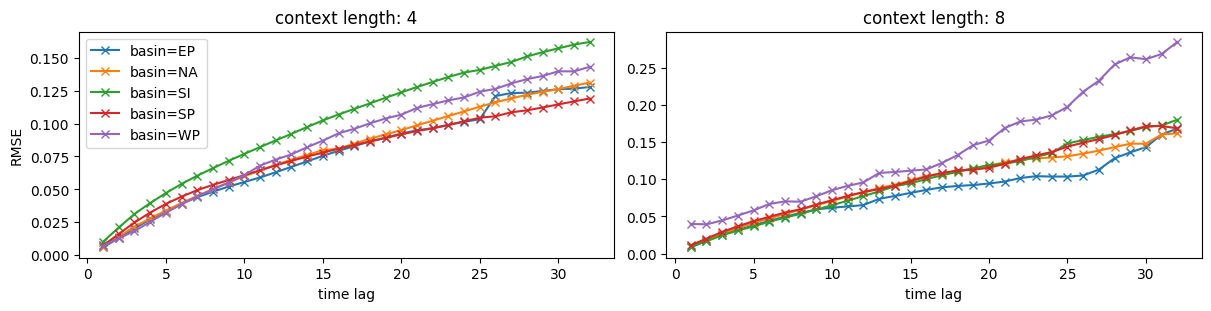

In [7]:
fig, ax = plt.subplots(nrows=1, ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,3)

for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    ax[idx_cl].plot(time_lags, errors[context_length][basin].values(), color=f"C{idx_b}", marker="x", label=f"basin={basin}")
    ax[idx_cl].set_title(f"context length: {context_length}")
    ax[idx_cl].set_xlabel("time lag")
ax[0].legend()
ax[0].set_ylabel("RMSE")

Text(0, 0.5, 'RMSE')

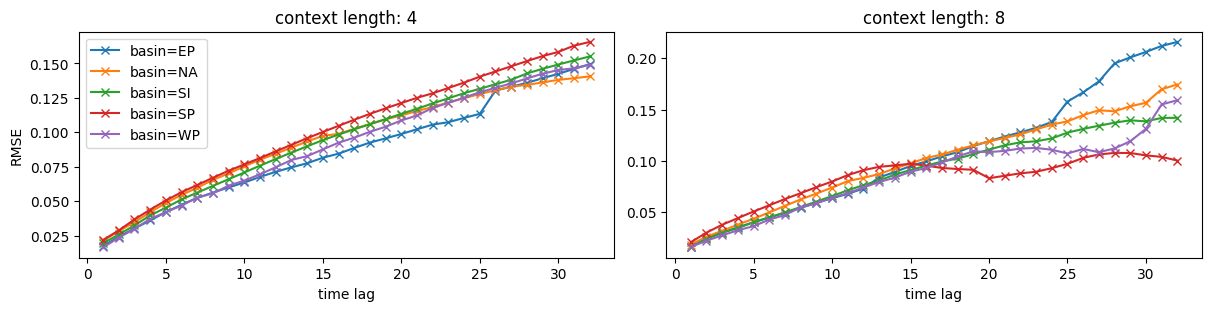

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,3)

for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    ax[idx_cl].plot(time_lags, errors[context_length][basin].values(), color=f"C{idx_b}", marker="x", label=f"basin={basin}")
    ax[idx_cl].set_title(f"context length: {context_length}")
    ax[idx_cl].set_xlabel("time lag")
ax[0].legend()
ax[0].set_ylabel("RMSE")

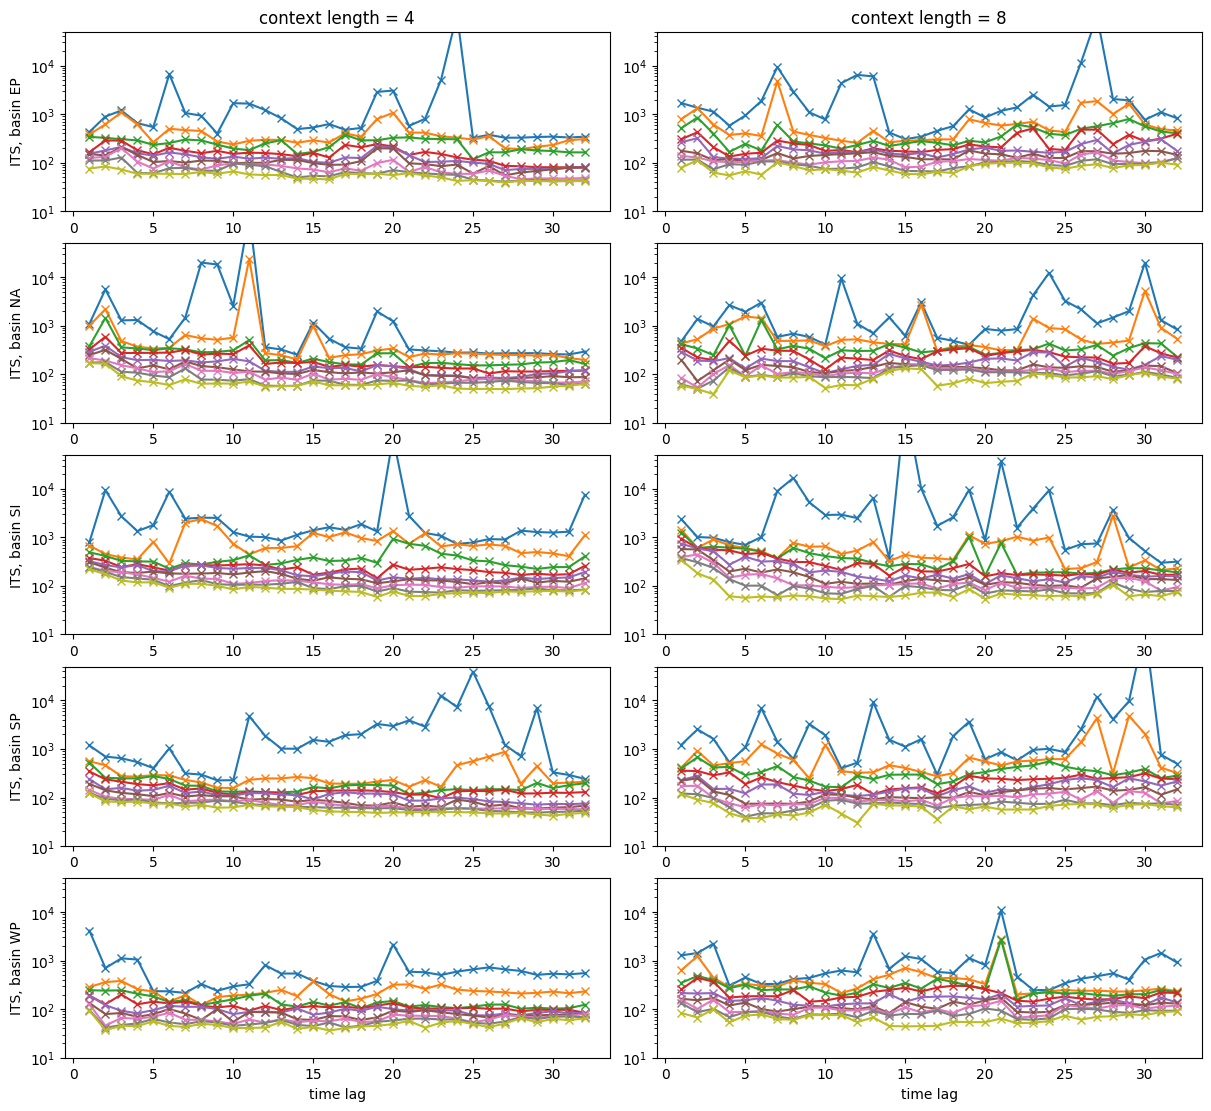

In [8]:
fig, ax = plt.subplots(nrows=len(basins), ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,11)

eval_range = range(1, 19, 2)
# eval_range = [1, 2, 3, 5, 8]
for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    for idx_eval_c, idx_eval in enumerate(eval_range):
        ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", label=idx_eval)
    if idx_b == 0:
        ax[idx_b, idx_cl].set_title(f"context length = {context_length}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_cl].set_xlabel("time lag")
    ax[idx_b, idx_cl].set_yscale("log")
    ax[idx_b, idx_cl].set_ylim(1E1, 5E4)
    ax[idx_b, 0].set_ylabel(f"ITS, basin {basin}")

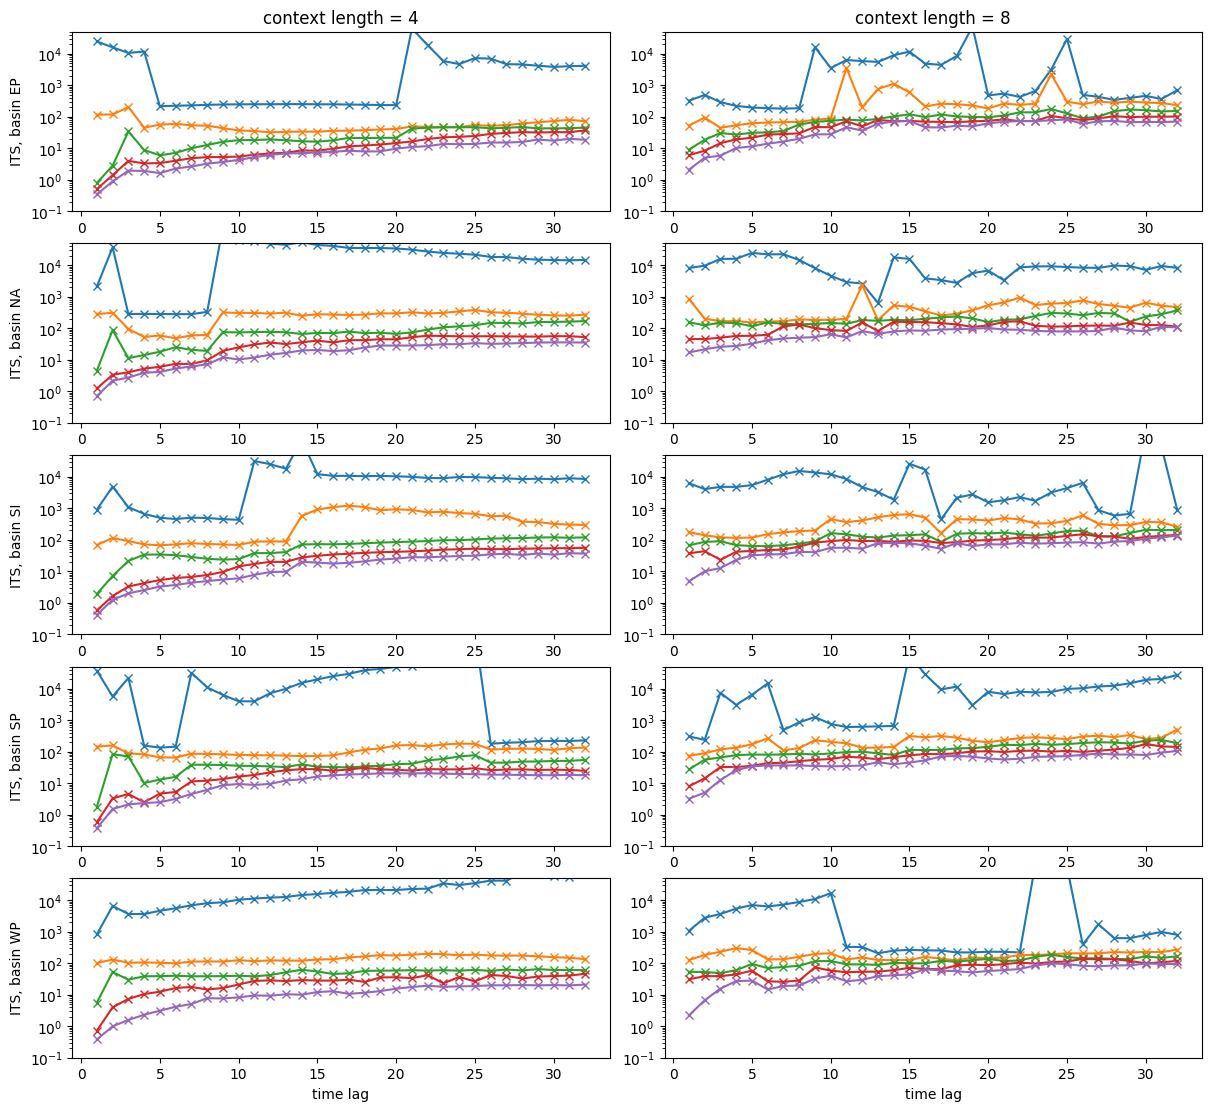

In [19]:
fig, ax = plt.subplots(nrows=len(basins), ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,11)

eval_range = range(0, 15, 3)
# eval_range = [1, 2, 3, 5, 8]
for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    for idx_eval_c, idx_eval in enumerate(eval_range):
        ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", label=idx_eval)
    if idx_b == 0:
        ax[idx_b, idx_cl].set_title(f"context length = {context_length}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_cl].set_xlabel("time lag")
    ax[idx_b, idx_cl].set_yscale("log")
    ax[idx_b, idx_cl].set_ylim(1E-1, 5E4)
    ax[idx_b, 0].set_ylabel(f"ITS, basin {basin}")

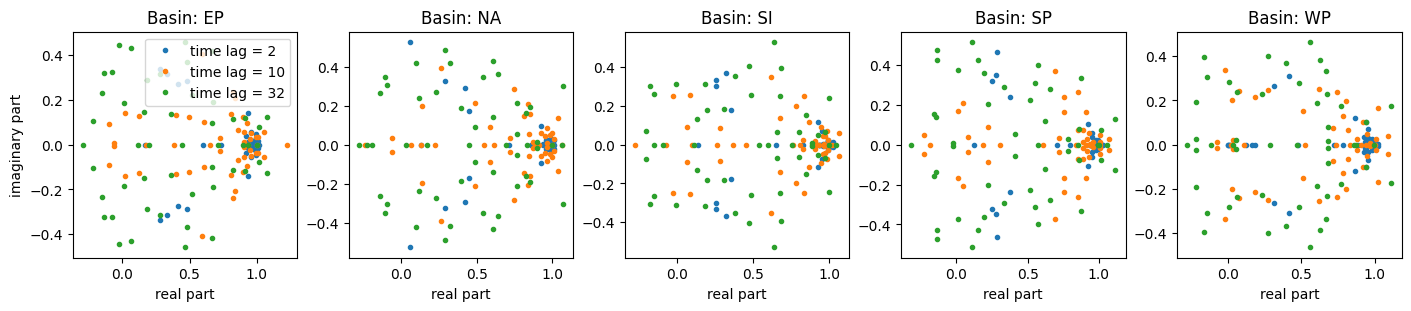

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=len(basins), constrained_layout = True)
fig.set_size_inches(14,3)

context_length = context_lengths[0]


for idx_b, basin in enumerate(basins):
    time_lag = time_lags[1]
    ax[idx_b].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, color=f"C{0}", marker=".", label=f"time lag = {time_lag}", linestyle="None")
    time_lag = time_lags[9]
    ax[idx_b].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, color=f"C{1}", marker=".", label=f"time lag = {time_lag}", linestyle="None")
    time_lag = time_lags[-1]
    ax[idx_b].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, color=f"C{2}", marker=".", label=f"time lag = {time_lag}", linestyle="None")

    ax[idx_b].set_title(f"Basin: {basin}")
    if idx_b == 0:
        ax[idx_b].set_ylabel(f"imaginary part")
    ax[idx_b].set_xlabel("real part")
ax[0].legend()

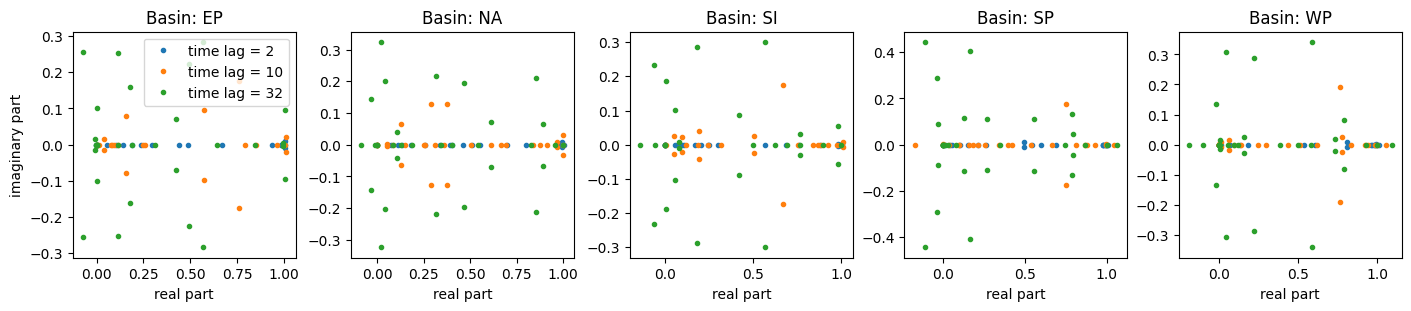

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=len(basins), constrained_layout = True)
fig.set_size_inches(14,3)

context_length = context_lengths[0]


for idx_b, basin in enumerate(basins):
    time_lag = time_lags[1]
    ax[idx_b].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, color=f"C{0}", marker=".", label=f"time lag = {time_lag}", linestyle="None")
    time_lag = time_lags[9]
    ax[idx_b].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, color=f"C{1}", marker=".", label=f"time lag = {time_lag}", linestyle="None")
    time_lag = time_lags[-1]
    ax[idx_b].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, color=f"C{2}", marker=".", label=f"time lag = {time_lag}", linestyle="None")

    ax[idx_b].set_title(f"Basin: {basin}")
    if idx_b == 0:
        ax[idx_b].set_ylabel(f"imaginary part")
    ax[idx_b].set_xlabel("real part")
ax[0].legend()

#### tk_reg 1e4

In [8]:
num_centers = 800
tikhonov_reg = 1E-4

# time_step_h = 0.5
time_step_h = 1.0
time_step_scaling = int(3 / time_step_h)
# BASINS = ["EP", "NA", "NI", "SI", "SP", "WP", "SA"]
basins = ["EP", "NA", "SI", "SP", "WP"]
# basins = BASINS[:-1]
year_range = (1980, 2021)
model_config = {
    "length_scale": 10.0,
    "reduced_rank": False,
    "rank": 50,
    "num_centers": num_centers,
    "tikhonov_reg": tikhonov_reg,
    "svd_solver": "arnoldi",
    "rng_seed": 42,
}
context_lengths = [4, 8]
top_k = 20
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    "radius_max_wind",
    "radius_oci",
    "central_pressure",
    "environmental_pressure",
]
time_lags = list(range(1, 33))

evals, errors, time_scales = load_data(time_step_h, year_range, num_centers, tikhonov_reg, context_lengths, time_lags)

Load data for context length: 4
Load data for context length: 8


Text(0, 0.5, 'RMSE')

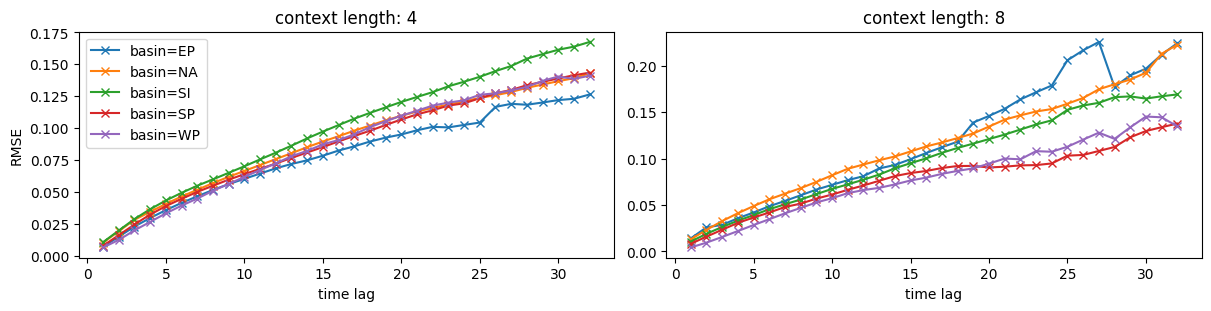

In [9]:
fig, ax = plt.subplots(nrows=1, ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,3)

for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    ax[idx_cl].plot(time_lags, errors[context_length][basin].values(), color=f"C{idx_b}", marker="x", label=f"basin={basin}")
    ax[idx_cl].set_title(f"context length: {context_length}")
    ax[idx_cl].set_xlabel("time lag")
ax[0].legend()
ax[0].set_ylabel("RMSE")

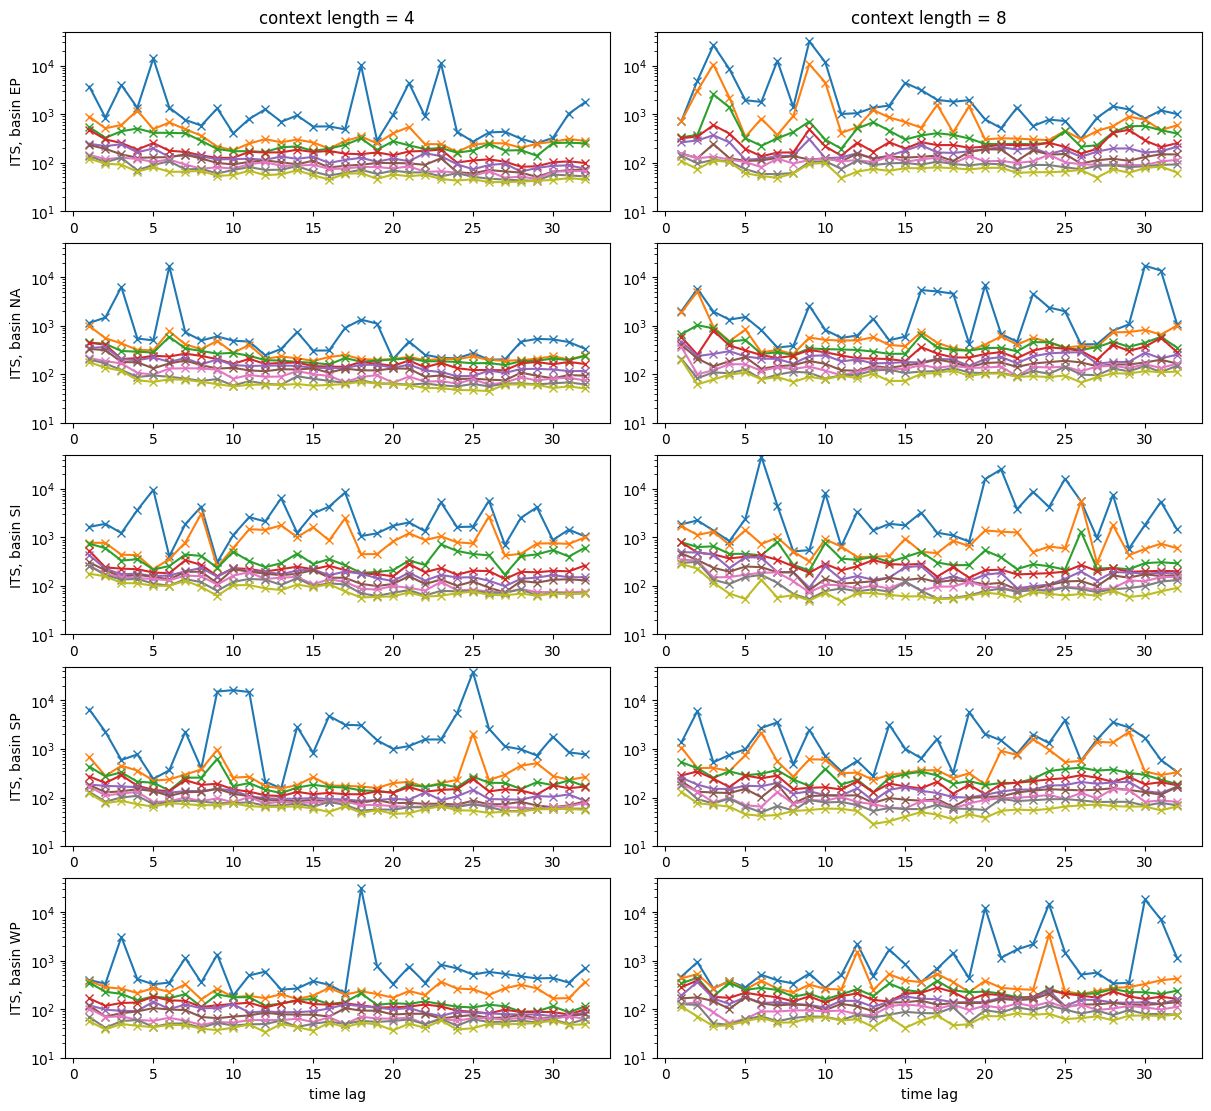

In [10]:
fig, ax = plt.subplots(nrows=len(basins), ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,11)

eval_range = range(1, 19, 2)
# eval_range = [1, 2, 3, 5, 8]
for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    for idx_eval_c, idx_eval in enumerate(eval_range):
        ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", label=idx_eval)
    if idx_b == 0:
        ax[idx_b, idx_cl].set_title(f"context length = {context_length}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_cl].set_xlabel("time lag")
    ax[idx_b, idx_cl].set_yscale("log")
    ax[idx_b, idx_cl].set_ylim(1E1, 5E4)
    ax[idx_b, 0].set_ylabel(f"ITS, basin {basin}")

### 1600 centers

#### tk_reg 1e8

In [28]:
num_centers = 1600
tikhonov_reg = 1E-8

# time_step_h = 0.5
time_step_h = 1.0
time_step_scaling = int(3 / time_step_h)
# BASINS = ["EP", "NA", "NI", "SI", "SP", "WP", "SA"]
basins = ["EP", "NA", "SI", "SP", "WP"]
# basins = BASINS[:-1]
year_range = (1980, 2021)
model_config = {
    "length_scale": 10.0,
    "reduced_rank": False,
    "rank": 50,
    "num_centers": num_centers,
    "tikhonov_reg": tikhonov_reg,
    "svd_solver": "arnoldi",
    "rng_seed": 42,
}
context_lengths = [4, 8]
top_k = 20
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    "radius_max_wind",
    "radius_oci",
    "central_pressure",
    "environmental_pressure",
]
time_lags = list(range(1, 33))

evals, errors, time_scales = load_data(time_step_h, year_range, num_centers, tikhonov_reg, context_lengths, time_lags)

Load data for context length: 4
Load data for context length: 8


Text(0, 0.5, 'RMSE')

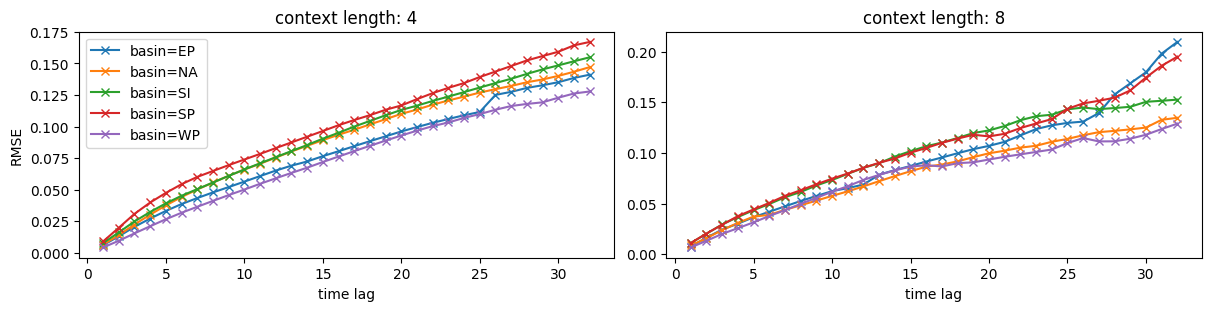

In [29]:
fig, ax = plt.subplots(nrows=1, ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,3)

for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    ax[idx_cl].plot(time_lags, errors[context_length][basin].values(), color=f"C{idx_b}", marker="x", label=f"basin={basin}")
    ax[idx_cl].set_title(f"context length: {context_length}")
    ax[idx_cl].set_xlabel("time lag")
ax[0].legend()
ax[0].set_ylabel("RMSE")

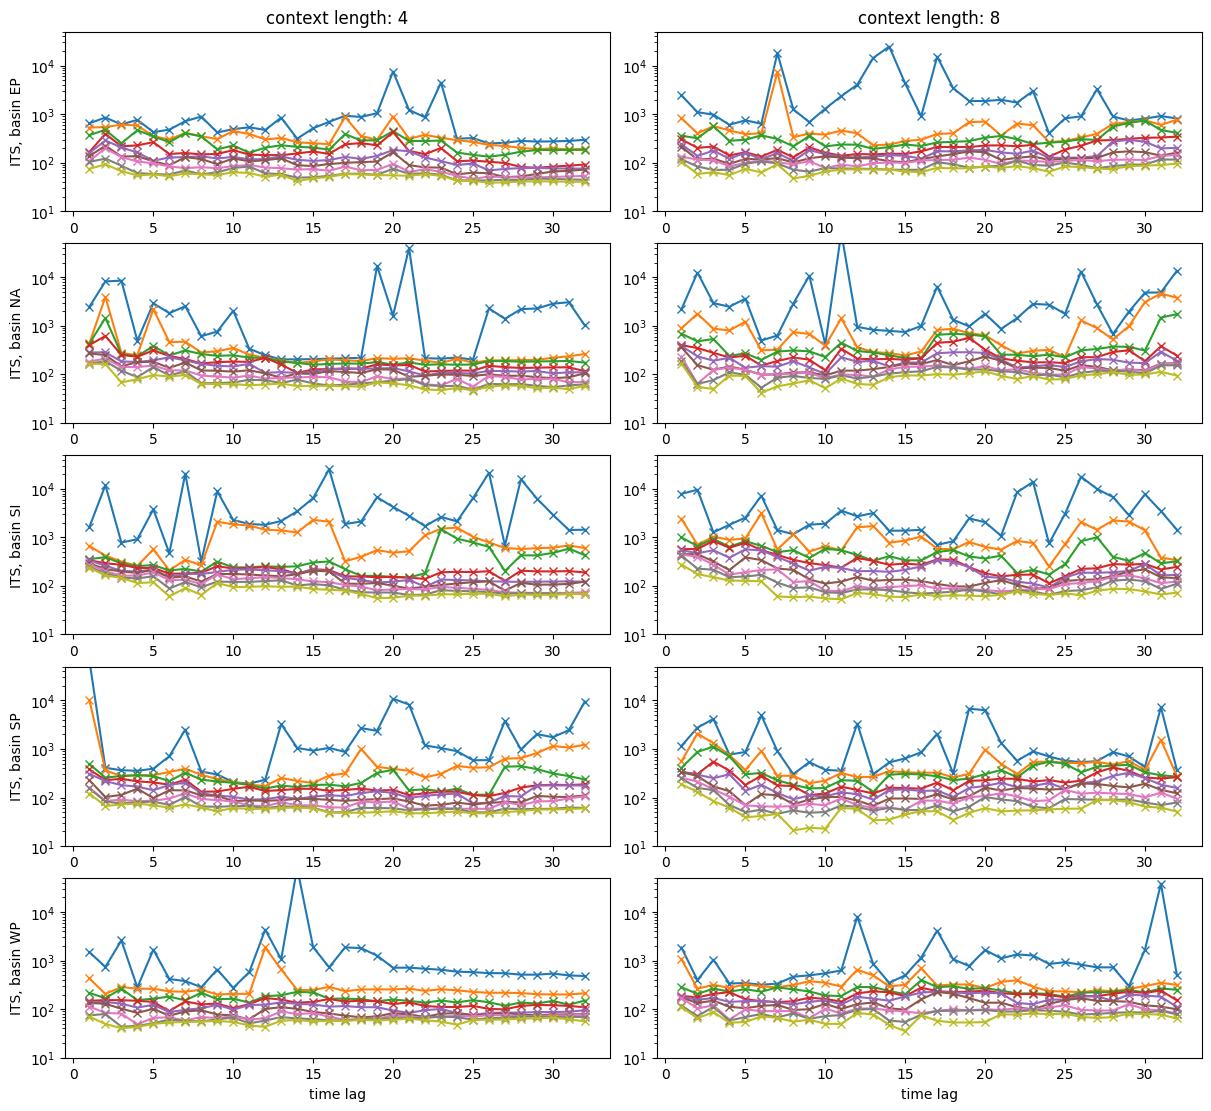

In [30]:
fig, ax = plt.subplots(nrows=len(basins), ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,11)

eval_range = range(1, 19, 2)
# eval_range = [1, 2, 3, 5, 8]
for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    for idx_eval_c, idx_eval in enumerate(eval_range):
        ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", label=idx_eval)
    if idx_b == 0:
        ax[idx_b, idx_cl].set_title(f"context length: {context_length}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_cl].set_xlabel("time lag")
    ax[idx_b, idx_cl].set_yscale("log")
    ax[idx_b, idx_cl].set_ylim(1E1, 5E4)
    ax[idx_b, 0].set_ylabel(f"ITS, basin {basin}")

#### tk_reg 1e4

In [22]:
num_centers = 1600
tikhonov_reg = 1E-4

# time_step_h = 0.5
time_step_h = 1.0
time_step_scaling = int(3 / time_step_h)
# BASINS = ["EP", "NA", "NI", "SI", "SP", "WP", "SA"]
basins = ["EP", "NA", "SI", "SP", "WP"]
# basins = BASINS[:-1]
year_range = (1980, 2021)
model_config = {
    "length_scale": 10.0,
    "reduced_rank": False,
    "rank": 50,
    "num_centers": num_centers,
    "tikhonov_reg": tikhonov_reg,
    "svd_solver": "arnoldi",
    "rng_seed": 42,
}
context_lengths = [4, 8]
top_k = 20
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    "radius_max_wind",
    "radius_oci",
    "central_pressure",
    "environmental_pressure",
]
time_lags = list(range(1, 33))

evals, errors, time_scales = load_data(time_step_h, year_range, num_centers, tikhonov_reg, context_lengths, time_lags)

Load data for context length: 4
Load data for context length: 8


Text(0, 0.5, 'RMSE')

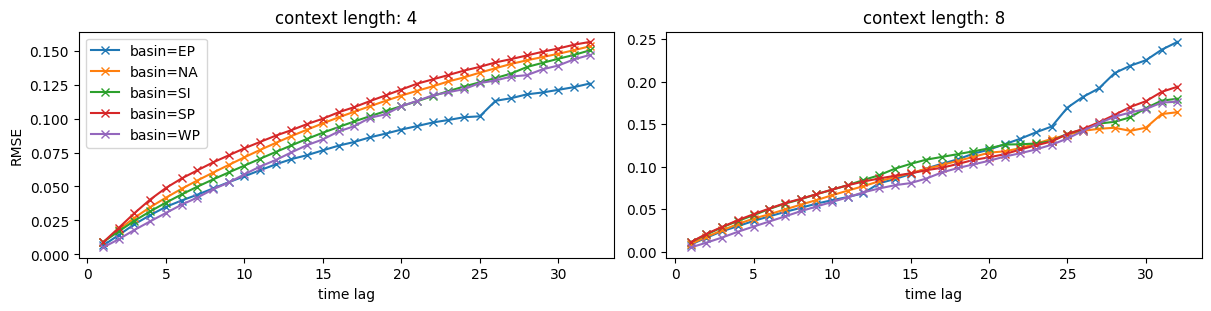

In [24]:
fig, ax = plt.subplots(nrows=1, ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,3)

for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    ax[idx_cl].plot(time_lags, errors[context_length][basin].values(), color=f"C{idx_b}", marker="x", label=f"basin={basin}")
    ax[idx_cl].set_title(f"context length: {context_length}")
    ax[idx_cl].set_xlabel("time lag")
ax[0].legend()
ax[0].set_ylabel("RMSE")

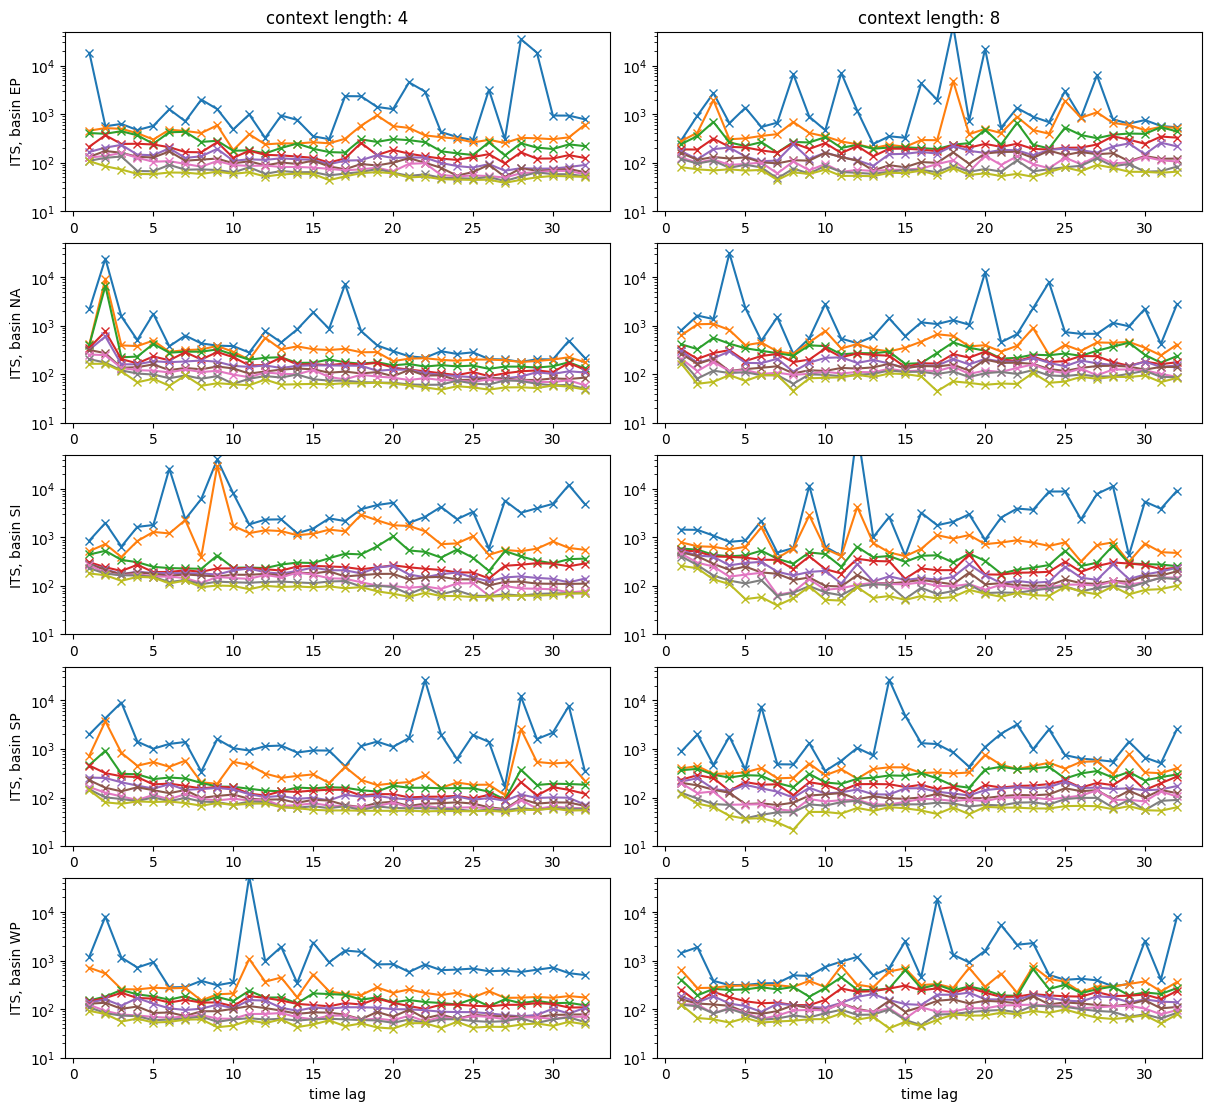

In [27]:
fig, ax = plt.subplots(nrows=len(basins), ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,11)

eval_range = range(1, 19, 2)
# eval_range = [1, 2, 3, 5, 8]
for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    for idx_eval_c, idx_eval in enumerate(eval_range):
        ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", label=idx_eval)
    if idx_b == 0:
        ax[idx_b, idx_cl].set_title(f"context length: {context_length}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_cl].set_xlabel("time lag")
    ax[idx_b, idx_cl].set_yscale("log")
    ax[idx_b, idx_cl].set_ylim(1E1, 5E4)
    ax[idx_b, 0].set_ylabel(f"ITS, basin {basin}")